**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

## video 8, 0:0:0

## Using SGD on MNIST

## Imports and data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
# from fastai.torch_imports import *
# from fastai.io import *

In [3]:
path = 'data/mnist/'

Let's download, unzip, and format the data.

In [4]:
import os
os.makedirs(path, exist_ok=True)

In [5]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [6]:
from fastai.io import *

In [7]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [8]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [9]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [10]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [11]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [12]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots 

In [13]:
x_valid.shape

(10000, 784)

In [16]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

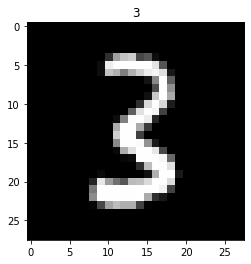

In [17]:
show(x_imgs[0], y_valid[0])

In [18]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [19]:
y_valid[0]

3

We can look at part of an image:

In [20]:
x_imgs[0,10:15,10:15]

array([[-0.42452, -0.42452, -0.42452, -0.42452,  0.17294],
       [-0.42452, -0.42452, -0.42452,  0.78312,  2.43567],
       [-0.42452, -0.27197,  1.20261,  2.77889,  2.80432],
       [-0.42452,  1.76194,  2.80432,  2.80432,  1.73651],
       [-0.42452,  2.20685,  2.80432,  2.80432,  0.40176]], dtype=float32)

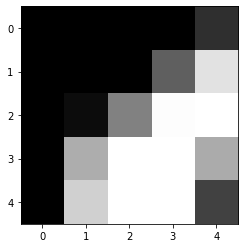

In [21]:
show(x_imgs[0,10:15,10:15])

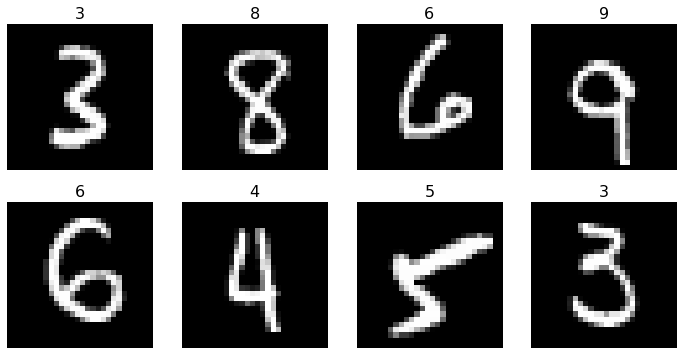

In [22]:
plots(x_imgs[:8], titles=y_valid[:8])

## Neural Networks

## Neural Net for Logistic Regression in PyTorch

In [23]:
import cv2

In [24]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class.  

In [25]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)# .cuda()

In [102]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)# .cuda()

Each input is a vector of size `28*28` pixels and our output is of size `10` (since there are 10 digits: 0, 1, ..., 9). 

We use the output of the final layer to generate our predictions.  Often for classification problems (like MNIST digit classification), the final layer has the same number of outputs as there are classes.  In that case, this is 10: one for each digit from 0 to 9.  These can be converted to comparative probabilities.  For instance, it may be determined that a particular hand-written image is 80% likely to be a 4, 18% likely to be a 9, and 2% likely to be a 3.

In [103]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [104]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())
# opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

### Fitting the model

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [105]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.333002   0.288532   0.9165    
    1      0.315638   0.275053   0.9205                       
    2      0.276797   0.274538   0.923                        
    3      0.297397   0.278255   0.9231                       
    4      0.278572   0.265895   0.923                        



[0.2658951123178005, 0.923]

In [84]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([7840, 10], 7850)

In [85]:
preds = predict(net, md.val_dl)

In [86]:
preds.shape

(10000, 10)

**Question**: Why does our output have length 10 (for each image)?

In [87]:
import pandas as pd
pd.DataFrame(preds[:5,]).T

,0,1,2,3,4
0,-11.613235,-15.761918,-5.322632,-13.193274,-11.657699
1,-5.737880,-11.276038,-15.956891,-11.327784,-14.403183
2,-2.905473,-5.138394,-3.810282,-6.270698,-2.812020
3,-0.092217,-4.826545,-8.732435,-7.171002,-11.133823
4,-11.009083,-5.164136,-5.283183,-3.786465,-11.152960
5,-4.601885,-4.896627,-3.910877,-10.647511,-7.678677
6,-7.809796,-14.187472,-0.053995,-12.103390,-0.064946
7,-18.369120,-12.717084,-8.585408,-2.749168,-22.506697
8,-3.928072,-0.027629,-9.652931,-8.822619,-6.076079
9,-12.925219,-8.719206,-10.421756,-0.093769,-16.600574


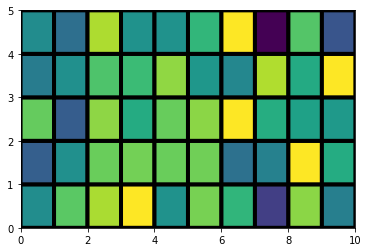

In [88]:
plt.pcolor(preds[:5,], edgecolor='k', linewidths=4)

In [90]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [91]:
preds_cat = preds.argmax(1)

Let's check how accurate this approach is on our validation set. You may want to compare this against other implementations of logistic regression, such as the one in sklearn. In our testing, this simple pytorch version is faster and more accurate for this problem!

In [92]:
np.mean(preds_cat == y_valid)

0.9249

Let's see how some of our predictions look!

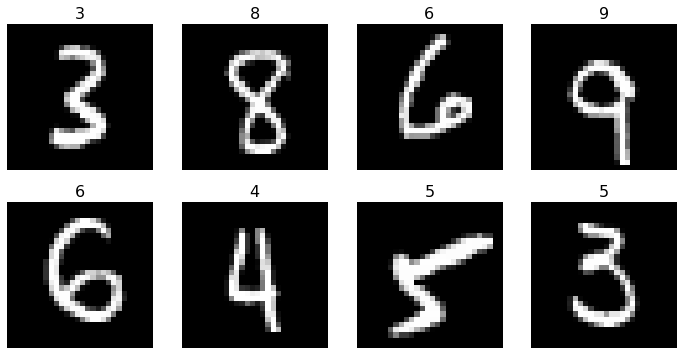

In [94]:
plots(x_imgs[:8], titles=preds_cat[:8])

## video 8, 1:18:52, again Video 8, 0:17:00

## Defining Logistic Regression Ourselves

Above, we used pytorch's `nn.Linear` to create a linear layer.  This is defined by a matrix multiplication and then an addition (these are also called `affine transformations`).  Let's try defining this ourselves.

Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  

Our PyTorch class needs two things: constructor (says what the parameters are) and a forward method (how to calculate a prediction using those parameters)  The method `forward` describes how the neural net converts inputs to outputs.

In PyTorch, the optimizer knows to try to optimize any attribute of type **Parameter**.

In [96]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])

In [97]:
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

In [98]:
# def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=0))

In [106]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [107]:
net2 = LogReg()# .cuda()
opt=optim.Adam(net2.parameters())

In [108]:
fit(net2, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.325349   0.287482   0.918     
    1      0.307786   0.267921   0.925                        
    2      0.278717   0.269497   0.9236                       
    3      0.29493    0.272435   0.925                        
    4      0.298881   0.263446   0.9261                       



[0.263446344101429, 0.9261]

## Video 9, 0:29:0

In [111]:
dl = iter(md.trn_dl)

In [112]:
xmb,ymb = next(dl)

In [113]:
xmb.shape, xmb

(torch.Size([64, 784]),
 tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         ...,
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]))

In [114]:
vxmb = Variable(xmb) # .cuda())
vxmb.shape, vxmb

(torch.Size([64, 784]),
 tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         ...,
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
         [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]]))

In [115]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[3.0998e-07, 1.2998e-09, 1.1840e-08, 4.0399e-06, 2.5264e-04, 9.9868e-01,
         5.2522e-07, 1.0419e-06, 1.0212e-03, 3.7939e-05],
        [6.1736e-06, 9.0959e-07, 5.0922e-03, 1.2821e-04, 9.8771e-01, 2.7827e-04,
         4.1729e-04, 2.6303e-03, 6.0731e-04, 3.1263e-03],
        [7.0863e-06, 3.7367e-08, 1.0054e-05, 1.0455e-04, 1.4685e-04, 9.6209e-04,
         9.5706e-09, 8.6370e-01, 4.0556e-03, 1.3102e-01]],
       grad_fn=<SliceBackward>)

In [116]:
preds_cat = preds.data.max(1)[1]; preds_cat

tensor([5, 4, 7, 2, 0, 3, 4, 8, 7, 9, 5, 2, 6, 7, 9, 4, 8, 7, 9, 0, 0, 9, 8, 8,
        7, 9, 8, 6, 2, 5, 6, 5, 2, 5, 4, 0, 1, 4, 3, 4, 4, 5, 3, 1, 5, 5, 7, 3,
        2, 9, 1, 9, 6, 6, 3, 7, 8, 3, 2, 1, 3, 1, 7, 6])

Let's look at our predictions on the first eight images:

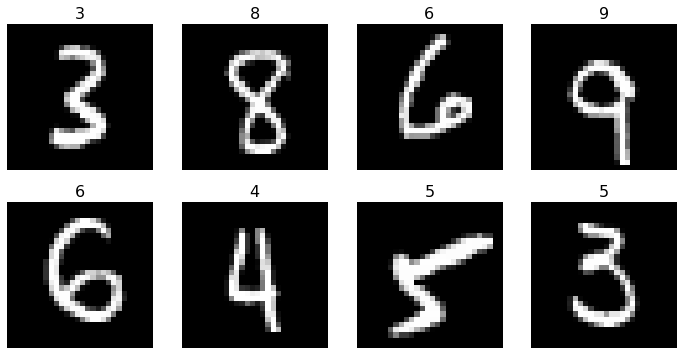

In [117]:
preds_cat = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds_cat[:8])

In [119]:
np.mean(preds_cat == y_valid)

0.9261

## Video 9, 00:47:00

## Broadcasting

## Video 9, 1:18:00, again Video 10, 0:08:40

## Writing Our Own Training Loop

As a reminder, this is what we did above to write our own logistic regression class (as a pytorch neural net):

In [123]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

net2 = LogReg()# .cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy                     
    0      0.334627   0.28231    0.9199    



[0.2823095627784729, 0.9199]

Above, we are using the fastai method `fit` to train our model.  Now we will try writing the training loop ourselves.

**Review question:** What does it mean to train a model?

We will use the LogReg class we created, as well as the same loss function, learning rate, and optimizer as before:

In [124]:
net2 = LogReg()# .cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

md is the ImageClassifierData object we created above.  We want an iterable version of our training data (**question**: what does it mean for something to be iterable?):

In [125]:
dl = iter(md.trn_dl) # Data loader

First, we will do a **forward pass**, which means computing the predicted y by passing x to the model.

In [126]:
xt, yt = next(dl)
y_pred = net2(Variable(xt)) # .cuda())

We can check the loss:

In [127]:
l = loss(y_pred, Variable(yt)) # .cuda())
print(l)

tensor(2.3189, grad_fn=<NllLossBackward>)


In [128]:
l = loss(y_pred, yt) # .cuda())
print(l)

tensor(2.3189, grad_fn=<NllLossBackward>)


We may also be interested in the accuracy.  We don't expect our first predictions to be very good, because the weights of our network were initialized to random values.  Our goal is to see the loss decrease (and the accuracy increase) as we train the network:

In [129]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.0625

Now we will use the optimizer to calculate which direction to step in.  That is, how should we update our weights to try to decrease the loss?

Pytorch has an automatic differentiation package ([autograd](http://pytorch.org/docs/master/autograd.html)) that takes derivatives for us, so we don't have to calculate the derivative ourselves!  We just call `.backward()` on our loss to calculate the direction of steepest descent (the direction to lower the loss the most).

In [130]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

Now, let's make another set of predictions and check if our loss is lower:

In [131]:
xt, yt = next(dl)
y_pred = net2(Variable(xt)) # .cuda())

In [132]:
l = loss(y_pred, Variable(yt)) # .cuda())
print(l)

tensor(2.1956, grad_fn=<NllLossBackward>)


In [133]:
l.item()

2.195610284805298

Note that we are using **stochastic** gradient descent, so the loss is not guaranteed to be strictly better each time.  The stochasticity comes from the fact that we are using **mini-batches**; we are just using 64 images to calculate our prediction and update the weights, not the whole dataset.

In [134]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.390625

If we run several iterations in a loop, we should see the loss decrease and the accuracy increase with time.

In [135]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt)) # .cuda())
    l = loss(y_pred, Variable(yt)) # .cuda())
    
    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        # print("loss: ", l.data[0], "\t accuracy: ", accuracy)
        print("loss: ", l.item(), "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  2.2435102462768555 	 accuracy:  0.34375
loss:  1.4500205516815186 	 accuracy:  0.640625
loss:  0.8260552883148193 	 accuracy:  0.859375
loss:  0.7496338486671448 	 accuracy:  0.75
loss:  0.8237600326538086 	 accuracy:  0.734375
loss:  0.580560028553009 	 accuracy:  0.859375
loss:  0.3808545768260956 	 accuracy:  0.9375
loss:  0.6797816157341003 	 accuracy:  0.859375
loss:  0.35532936453819275 	 accuracy:  0.953125
loss:  0.5046951174736023 	 accuracy:  0.859375


### Put it all together in a training loop

In [136]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [179]:
net2 = LogReg() # .cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

losses=[]
for epoch in range(10):
    # dl = iter(md.trn_dl)
    # for t in range(len(dl)):
    for t in md.trn_dl:
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = t
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    # val_dl = iter(md.val_dl)
    val_scores = [score(x, y) for x, y in md.val_dl]
    print(epoch, to_np(losses[epoch]).flat[0], np.mean(val_scores))

0 2.3111897 0.9094347133757962
1 2.1700318 0.9166998407643312
2 2.0426586 0.9175955414012739
3 1.99773 0.9184912420382165
4 1.93587 0.9210788216560509
5 1.8343402 0.9220740445859873
6 1.8574357 0.9214769108280255
7 1.689057 0.9228702229299363
8 1.6798449 0.9240644904458599
9 1.5721719 0.9249601910828026


## Video 10, 00:18:24

## Stochastic Gradient Descent

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent (SGD)**. SGD can be seeing as an approximation of **gradient descent (GD)**. In GD you have to run through all the samples in your training set to do a single itaration. In SGD you use only a subset of training samples to do the update for a parameter in a particular iteration. The subset used in each iteration is called a batch or minibatch.

Now, instead of using the optimizer, we will do the optimization ourselves!

In [188]:
net2 = LogReg() # .cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b

losses=[]
for epoch in range(10):
    # dl = iter(md.trn_dl)
    for t in md.trn_dl:
        xt, yt = t
        y_pred = net2(V(xt))
        l = loss(y_pred, Variable(yt)) # .cuda())
        losses.append(l)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   

    # val_dl = iter(md.val_dl)
    val_scores = [score(x, y) for x, y in md.val_dl]
    print(epoch, to_np(losses[epoch]).flat[0], np.mean(val_scores))
    # print(epoch, np.mean(val_scores))

0 2.3207574 0.9072452229299363
1 2.1594343 0.9165007961783439
2 2.05861 0.9178941082802548
3 1.9611077 0.9193869426751592
4 1.8993546 0.9209792993630573
5 1.8760896 0.9223726114649682
6 1.72915 0.9236664012738853
7 1.6738513 0.9234673566878981
8 1.5542694 0.9232683121019108
9 1.5904092 0.9249601910828026


## Video 10, 00:29:00 - 00:33:00 Going backwards

## Video 10, 00:33:00 Deep networks

## Video 10, 00:42:00 - 00:58:00, Regularization

## Video 10, 00:58:00 - 1:02:00, Big vs. Small Models

## Video 10, 1:02:00 IMDB